# Wasserstein GAN in Pytorch for CIFAR10

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [3]:
bs, sz, nz = 64, 64, 100 # nz is the size of the latent z vector

In [4]:
# My custom codes
# Where to store samples and models
experiment_path = 'wgan_samples'

In [ ]:
os.system('mkdir {0}'.format(experiment_path))

In [5]:
# Fix seed
manual_seed = random.randint(1, 10000)
print(manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

1738


In [6]:
cudnn.benchmark = True

Pytorch has the handy [torch-vision](https://github.com/pytorch/vision) library which makes handling images fast and easy.

In [7]:
PATH = 'data/cifar10'
data = datasets.CIFAR10(root=PATH, download=True,
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified


Even parallel processing is handling automatically by torch-vision.

In [8]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader)
n

782

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [9]:
def show(img, fs=(6,6)):
    plt.figure(figsize=fs)
    plt.imshow(np.transpose((img / 2 + 0.5).clamp(0, 1).numpy(), (1, 2, 0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [10]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [11]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [12]:
# nc is input image channels = 3
# ngf is number of generator filter = 64
# ngpu is number of GPUs to use = 1
# n_extra_layers is number of extra layers on gen and disc = 1
netG = DCGAN_G(sz, nz, 3, 64, 1, 1).cuda()
netG.apply(weights_init)

DCGAN_G(
  (main): Sequential(
    (initial-100.512.convt): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial-512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial-512.relu): ReLU(inplace)
    (pyramid-512.256.convt): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): ReLU(inplace)
    (pyramid-256.128.convt): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): ReLU(inplace)
    (pyramid-128.64.convt): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-64.relu): ReLU(inplace)
    (extra-0-64.64.convt):

In [13]:
netD = DCGAN_D(sz, 3, 64, 1, 1).cuda()
netD.apply(weights_init)

DCGAN_D(
  (main): Sequential(
    (initial-3.64.conv): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (initial-64.relu): LeakyReLU(0.2, inplace)
    (extra-0-64.64.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (extra-0-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (extra-0-64.relu): LeakyReLU(0.2, inplace)
    (pyramid-64.128.conv): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): LeakyReLU(0.2, inplace)
    (pyramid-128.256.conv): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): LeakyReLU(0.2, inplace)
    (pyramid-256.512.co

Just some shortcuts to create tensors and variables.

### Continue Training (my custom codes)

In [28]:
netG_checkpoint = experiment_path + '/netG_epoch_1.pth'
netD_checkpoint = experiment_path + '/netD_epoch_1.pth'

# set path to netG_checkpoint (to continue training)
netG_model = '' # netG_checkpoint
netD_model = '' # netD_checkpoint

if netG_model != '':
    netG.load_state_dict(torch.load(netG_model))
    print('continue training generator/actor')

if netD_model != '':
    netD.load_state_dict(torch.load(netD_model))
    print('continue training discriminator/critic')

In [14]:
from torch import FloatTensor as FT

In [15]:
def Var(*params):
    return Variable( FT(*params).cuda() )

In [16]:
def create_noise(b): 
    return Variable( FT(b, nz, 1, 1).cuda().normal_(0, 1) )

In [17]:
# Input placeholder
input = Var(bs, 3, sz, nz)

# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)

# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [18]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [19]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [20]:
def make_trainable(net, val):
    for p in net.parameters(): # reset requires_grad
        p.requires_grad = val # they are set to False below in netG update

In [26]:
def train(niter, first=True):
    
    gen_iterations = 0
    
    for epoch in range(niter):
        data_iter = iter(dataloader)
        i = 0
        
        while i < n:
            ###########################
            # (1) Update D network
            ###########################
            make_trainable(netD, True)
            
            # train the discriminator d_iters times
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5) # 5 is number of D iters per each G iter

            j = 0
            
            while j < d_iters and i < n:
                j += 1
                i += 1
                
                # clamp parameters to a cube
                for p in netD.parameters():
                    p.data.clamp_(-0.01, 0.01)

                # my custom codes
                data = next(data_iter)
                
                # train with real
                real_cpu, _ = data # my custom codes
                real_cpu = real_cpu.cuda() # my custom codes
                real = Variable( data[0].cuda() )
                netD.zero_grad()
                errD_real = step_D(real, one)

                # train with fake
                fake = netG( create_noise(real.size()[0]) )
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            ###########################
            # (2) Update G network
            ###########################
            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
                % (epoch, niter, i, n, gen_iterations,
                errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

            if gen_iterations % 8 == 0: # every 500 generator iterations
                print('saving real and fake images...')
                real_cpu = real_cpu.mul(0.5).add(0.5)
                vutils.save_image(real_cpu, '{0}/real_samples.png'.format(experiment_path))
                fake = netG(create_noise(bs)) # create_noise replaced these codes: Variable(fixed_noise, volatile=True)
                fake.data = fake.data.mul(0.5).add(0.5)
                vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(experiment_path, gen_iterations))
          
        # do checkpointing
        torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment_path, epoch))
        torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment_path, epoch))
        
#         print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
#             epoch, niter, gen_iterations, n,
#             errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

In [ ]:
%time train(200, True)

[0/200][100/782][1] Loss_D: -1.563634 Loss_G: 0.752265 Loss_D_real: -0.826792 Loss_D_fake 0.736842
[0/200][200/782][2] Loss_D: -1.567946 Loss_G: 0.757642 Loss_D_real: -0.825479 Loss_D_fake 0.742468
[0/200][300/782][3] Loss_D: -1.561645 Loss_G: 0.752196 Loss_D_real: -0.824908 Loss_D_fake 0.736737
[0/200][400/782][4] Loss_D: -1.564565 Loss_G: 0.752433 Loss_D_real: -0.826539 Loss_D_fake 0.738026
[0/200][500/782][5] Loss_D: -1.564959 Loss_G: 0.752972 Loss_D_real: -0.826205 Loss_D_fake 0.738754
[0/200][600/782][6] Loss_D: -1.551300 Loss_G: 0.740083 Loss_D_real: -0.825433 Loss_D_fake 0.725867
[0/200][700/782][7] Loss_D: -1.559474 Loss_G: 0.749005 Loss_D_real: -0.825582 Loss_D_fake 0.733892
[0/200][782/782][8] Loss_D: -1.543361 Loss_G: 0.736540 Loss_D_real: -0.824774 Loss_D_fake 0.718588
saving real and fake images...
[1/200][100/782][9] Loss_D: -1.558775 Loss_G: 0.748187 Loss_D_real: -0.826058 Loss_D_fake 0.732717
[1/200][200/782][10] Loss_D: -1.551766 Loss_G: 0.737815 Loss_D_real: -0.826057

[3/200][380/782][81] Loss_D: -1.502671 Loss_G: 0.688224 Loss_D_real: -0.827703 Loss_D_fake 0.674967
[3/200][385/782][82] Loss_D: -1.502270 Loss_G: 0.688419 Loss_D_real: -0.827159 Loss_D_fake 0.675111
[3/200][390/782][83] Loss_D: -1.502533 Loss_G: 0.688248 Loss_D_real: -0.827481 Loss_D_fake 0.675053
[3/200][395/782][84] Loss_D: -1.503210 Loss_G: 0.688611 Loss_D_real: -0.828015 Loss_D_fake 0.675195
[3/200][400/782][85] Loss_D: -1.502063 Loss_G: 0.688513 Loss_D_real: -0.826814 Loss_D_fake 0.675248
[3/200][405/782][86] Loss_D: -1.502359 Loss_G: 0.688039 Loss_D_real: -0.827933 Loss_D_fake 0.674426
[3/200][410/782][87] Loss_D: -1.502103 Loss_G: 0.688194 Loss_D_real: -0.827093 Loss_D_fake 0.675010
[3/200][415/782][88] Loss_D: -1.502323 Loss_G: 0.688614 Loss_D_real: -0.826931 Loss_D_fake 0.675391
saving real and fake images...
[3/200][420/782][89] Loss_D: -1.502771 Loss_G: 0.688236 Loss_D_real: -0.828068 Loss_D_fake 0.674703
[3/200][425/782][90] Loss_D: -1.503076 Loss_G: 0.688837 Loss_D_real: 

[3/200][775/782][160] Loss_D: -1.502863 Loss_G: 0.688942 Loss_D_real: -0.827323 Loss_D_fake 0.675540
saving real and fake images...
[3/200][780/782][161] Loss_D: -1.504765 Loss_G: 0.689933 Loss_D_real: -0.828452 Loss_D_fake 0.676313
[3/200][782/782][162] Loss_D: -1.505282 Loss_G: 0.689487 Loss_D_real: -0.829156 Loss_D_fake 0.676127
[4/200][5/782][163] Loss_D: -1.502469 Loss_G: 0.689031 Loss_D_real: -0.826753 Loss_D_fake 0.675716
[4/200][10/782][164] Loss_D: -1.500597 Loss_G: 0.688797 Loss_D_real: -0.825233 Loss_D_fake 0.675364
[4/200][15/782][165] Loss_D: -1.495702 Loss_G: 0.686465 Loss_D_real: -0.821928 Loss_D_fake 0.673773
[4/200][20/782][166] Loss_D: -1.497139 Loss_G: 0.688416 Loss_D_real: -0.823473 Loss_D_fake 0.673665
[4/200][25/782][167] Loss_D: -1.502723 Loss_G: 0.689361 Loss_D_real: -0.826766 Loss_D_fake 0.675956
[4/200][30/782][168] Loss_D: -1.504275 Loss_G: 0.689819 Loss_D_real: -0.828764 Loss_D_fake 0.675512
saving real and fake images...
[4/200][35/782][169] Loss_D: -1.5033

[4/200][385/782][239] Loss_D: -1.483965 Loss_G: 0.687975 Loss_D_real: -0.809708 Loss_D_fake 0.674257
[4/200][390/782][240] Loss_D: -1.488870 Loss_G: 0.690012 Loss_D_real: -0.813903 Loss_D_fake 0.674966
saving real and fake images...
[4/200][395/782][241] Loss_D: -1.491549 Loss_G: 0.689801 Loss_D_real: -0.816045 Loss_D_fake 0.675504
[4/200][400/782][242] Loss_D: -1.492495 Loss_G: 0.689219 Loss_D_real: -0.818673 Loss_D_fake 0.673822
[4/200][405/782][243] Loss_D: -1.487813 Loss_G: 0.688788 Loss_D_real: -0.812590 Loss_D_fake 0.675223
[4/200][410/782][244] Loss_D: -1.492620 Loss_G: 0.688974 Loss_D_real: -0.817385 Loss_D_fake 0.675234
[4/200][415/782][245] Loss_D: -1.493930 Loss_G: 0.689358 Loss_D_real: -0.818862 Loss_D_fake 0.675068
[4/200][420/782][246] Loss_D: -1.490933 Loss_G: 0.689505 Loss_D_real: -0.816292 Loss_D_fake 0.674641
[4/200][425/782][247] Loss_D: -1.490147 Loss_G: 0.688715 Loss_D_real: -0.814872 Loss_D_fake 0.675275
[4/200][430/782][248] Loss_D: -1.494289 Loss_G: 0.689891 Los

[4/200][780/782][318] Loss_D: -1.496598 Loss_G: 0.697689 Loss_D_real: -0.815229 Loss_D_fake 0.681368
[4/200][782/782][319] Loss_D: -1.488208 Loss_G: 0.694905 Loss_D_real: -0.809709 Loss_D_fake 0.678500
[5/200][5/782][320] Loss_D: -1.496809 Loss_G: 0.697101 Loss_D_real: -0.815085 Loss_D_fake 0.681724
saving real and fake images...
[5/200][10/782][321] Loss_D: -1.497516 Loss_G: 0.697880 Loss_D_real: -0.814623 Loss_D_fake 0.682893
[5/200][15/782][322] Loss_D: -1.496217 Loss_G: 0.698158 Loss_D_real: -0.812143 Loss_D_fake 0.684074
[5/200][20/782][323] Loss_D: -1.501569 Loss_G: 0.699184 Loss_D_real: -0.817764 Loss_D_fake 0.683804
[5/200][25/782][324] Loss_D: -1.499932 Loss_G: 0.699582 Loss_D_real: -0.815559 Loss_D_fake 0.684373
[5/200][30/782][325] Loss_D: -1.498966 Loss_G: 0.698151 Loss_D_real: -0.816574 Loss_D_fake 0.682392
[5/200][35/782][326] Loss_D: -1.500080 Loss_G: 0.700592 Loss_D_real: -0.815534 Loss_D_fake 0.684546
[5/200][40/782][327] Loss_D: -1.502059 Loss_G: 0.701188 Loss_D_real:

[5/200][390/782][397] Loss_D: -1.524066 Loss_G: 0.715832 Loss_D_real: -0.823534 Loss_D_fake 0.700532
[5/200][395/782][398] Loss_D: -1.520022 Loss_G: 0.714352 Loss_D_real: -0.821121 Loss_D_fake 0.698901
[5/200][400/782][399] Loss_D: -1.525252 Loss_G: 0.716588 Loss_D_real: -0.823767 Loss_D_fake 0.701485
[5/200][405/782][400] Loss_D: -1.520722 Loss_G: 0.713606 Loss_D_real: -0.821642 Loss_D_fake 0.699080
saving real and fake images...
[5/200][410/782][401] Loss_D: -1.525114 Loss_G: 0.716607 Loss_D_real: -0.824228 Loss_D_fake 0.700885
[5/200][415/782][402] Loss_D: -1.515130 Loss_G: 0.711893 Loss_D_real: -0.819981 Loss_D_fake 0.695149
[5/200][420/782][403] Loss_D: -1.523715 Loss_G: 0.716901 Loss_D_real: -0.823535 Loss_D_fake 0.700180
[5/200][425/782][404] Loss_D: -1.526505 Loss_G: 0.714635 Loss_D_real: -0.824724 Loss_D_fake 0.701781
[5/200][430/782][405] Loss_D: -1.521434 Loss_G: 0.713648 Loss_D_real: -0.823327 Loss_D_fake 0.698107
[5/200][435/782][406] Loss_D: -1.521296 Loss_G: 0.711791 Los

[5/200][782/782][476] Loss_D: -1.502699 Loss_G: 0.691468 Loss_D_real: -0.821750 Loss_D_fake 0.680950
[6/200][5/782][477] Loss_D: -1.507478 Loss_G: 0.693988 Loss_D_real: -0.826565 Loss_D_fake 0.680913
[6/200][10/782][478] Loss_D: -1.505885 Loss_G: 0.695367 Loss_D_real: -0.824622 Loss_D_fake 0.681263
[6/200][15/782][479] Loss_D: -1.504550 Loss_G: 0.693380 Loss_D_real: -0.824490 Loss_D_fake 0.680060
[6/200][20/782][480] Loss_D: -1.505958 Loss_G: 0.694618 Loss_D_real: -0.825463 Loss_D_fake 0.680495
saving real and fake images...
[6/200][25/782][481] Loss_D: -1.508666 Loss_G: 0.695606 Loss_D_real: -0.826322 Loss_D_fake 0.682344
[6/200][30/782][482] Loss_D: -1.506316 Loss_G: 0.694965 Loss_D_real: -0.825171 Loss_D_fake 0.681145
[6/200][35/782][483] Loss_D: -1.505827 Loss_G: 0.695058 Loss_D_real: -0.825076 Loss_D_fake 0.680751
[6/200][40/782][484] Loss_D: -1.508106 Loss_G: 0.695283 Loss_D_real: -0.826647 Loss_D_fake 0.681458
[6/200][45/782][485] Loss_D: -1.509031 Loss_G: 0.696459 Loss_D_real: 

[6/200][490/782][555] Loss_D: -1.507025 Loss_G: 0.692684 Loss_D_real: -0.828049 Loss_D_fake 0.678976
[6/200][495/782][556] Loss_D: -1.508755 Loss_G: 0.692347 Loss_D_real: -0.829465 Loss_D_fake 0.679290
[6/200][500/782][557] Loss_D: -1.507136 Loss_G: 0.691482 Loss_D_real: -0.828951 Loss_D_fake 0.678185
[6/200][505/782][558] Loss_D: -1.506261 Loss_G: 0.691145 Loss_D_real: -0.828570 Loss_D_fake 0.677691
[6/200][510/782][559] Loss_D: -1.506693 Loss_G: 0.691983 Loss_D_real: -0.828589 Loss_D_fake 0.678104
[6/200][515/782][560] Loss_D: -1.490371 Loss_G: 0.689287 Loss_D_real: -0.812689 Loss_D_fake 0.677682
saving real and fake images...
[6/200][520/782][561] Loss_D: -1.479004 Loss_G: 0.681606 Loss_D_real: -0.805911 Loss_D_fake 0.673092
[6/200][525/782][562] Loss_D: -1.501046 Loss_G: 0.691344 Loss_D_real: -0.825264 Loss_D_fake 0.675782
[6/200][530/782][563] Loss_D: -1.506346 Loss_G: 0.692462 Loss_D_real: -0.827941 Loss_D_fake 0.678406
[6/200][535/782][564] Loss_D: -1.506201 Loss_G: 0.691047 Los

[7/200][100/782][634] Loss_D: -1.505979 Loss_G: 0.690965 Loss_D_real: -0.828547 Loss_D_fake 0.677432
[7/200][105/782][635] Loss_D: -1.505930 Loss_G: 0.690572 Loss_D_real: -0.828563 Loss_D_fake 0.677368
[7/200][110/782][636] Loss_D: -1.506162 Loss_G: 0.690941 Loss_D_real: -0.829105 Loss_D_fake 0.677057
[7/200][115/782][637] Loss_D: -1.507281 Loss_G: 0.691167 Loss_D_real: -0.829818 Loss_D_fake 0.677464
[7/200][120/782][638] Loss_D: -1.506292 Loss_G: 0.691100 Loss_D_real: -0.828772 Loss_D_fake 0.677520
[7/200][125/782][639] Loss_D: -1.505820 Loss_G: 0.691246 Loss_D_real: -0.828482 Loss_D_fake 0.677339
[7/200][130/782][640] Loss_D: -1.505253 Loss_G: 0.691068 Loss_D_real: -0.827717 Loss_D_fake 0.677536
saving real and fake images...
[7/200][135/782][641] Loss_D: -1.506153 Loss_G: 0.691114 Loss_D_real: -0.828781 Loss_D_fake 0.677372
[7/200][140/782][642] Loss_D: -1.505494 Loss_G: 0.690319 Loss_D_real: -0.828579 Loss_D_fake 0.676915
[7/200][145/782][643] Loss_D: -1.505792 Loss_G: 0.690689 Los

[7/200][495/782][713] Loss_D: -1.504950 Loss_G: 0.690971 Loss_D_real: -0.827162 Loss_D_fake 0.677788
[7/200][500/782][714] Loss_D: -1.499540 Loss_G: 0.688763 Loss_D_real: -0.825064 Loss_D_fake 0.674476
[7/200][505/782][715] Loss_D: -1.506206 Loss_G: 0.691266 Loss_D_real: -0.829150 Loss_D_fake 0.677056
[7/200][510/782][716] Loss_D: -1.505020 Loss_G: 0.690925 Loss_D_real: -0.827635 Loss_D_fake 0.677384
[7/200][515/782][717] Loss_D: -1.503527 Loss_G: 0.690673 Loss_D_real: -0.826789 Loss_D_fake 0.676738
[7/200][520/782][718] Loss_D: -1.504640 Loss_G: 0.690495 Loss_D_real: -0.827290 Loss_D_fake 0.677351
[7/200][525/782][719] Loss_D: -1.503914 Loss_G: 0.690311 Loss_D_real: -0.827056 Loss_D_fake 0.676858
[7/200][530/782][720] Loss_D: -1.503958 Loss_G: 0.690185 Loss_D_real: -0.827963 Loss_D_fake 0.675995
saving real and fake images...
[7/200][535/782][721] Loss_D: -1.493902 Loss_G: 0.686325 Loss_D_real: -0.821601 Loss_D_fake 0.672301
[7/200][540/782][722] Loss_D: -1.500873 Loss_G: 0.689132 Los

[8/200][105/782][792] Loss_D: -1.505759 Loss_G: 0.691586 Loss_D_real: -0.828075 Loss_D_fake 0.677685
saving real and fake images...
[8/200][110/782][793] Loss_D: -1.505711 Loss_G: 0.691660 Loss_D_real: -0.827760 Loss_D_fake 0.677951
[8/200][115/782][794] Loss_D: -1.505980 Loss_G: 0.691739 Loss_D_real: -0.828073 Loss_D_fake 0.677907
[8/200][120/782][795] Loss_D: -1.506935 Loss_G: 0.691176 Loss_D_real: -0.828456 Loss_D_fake 0.678479
[8/200][125/782][796] Loss_D: -1.504717 Loss_G: 0.691387 Loss_D_real: -0.826929 Loss_D_fake 0.677788
[8/200][130/782][797] Loss_D: -1.501378 Loss_G: 0.690288 Loss_D_real: -0.824769 Loss_D_fake 0.676609
[8/200][135/782][798] Loss_D: -1.505225 Loss_G: 0.691631 Loss_D_real: -0.827652 Loss_D_fake 0.677573
[8/200][140/782][799] Loss_D: -1.506341 Loss_G: 0.692040 Loss_D_real: -0.827880 Loss_D_fake 0.678461
[8/200][145/782][800] Loss_D: -1.506837 Loss_G: 0.692072 Loss_D_real: -0.828600 Loss_D_fake 0.678236
saving real and fake images...
[8/200][150/782][801] Loss_D:

[8/200][500/782][871] Loss_D: -1.508056 Loss_G: 0.692580 Loss_D_real: -0.829346 Loss_D_fake 0.678710
[8/200][505/782][872] Loss_D: -1.506790 Loss_G: 0.691908 Loss_D_real: -0.828458 Loss_D_fake 0.678332
saving real and fake images...
[8/200][510/782][873] Loss_D: -1.507310 Loss_G: 0.692638 Loss_D_real: -0.828676 Loss_D_fake 0.678634
[8/200][515/782][874] Loss_D: -1.507285 Loss_G: 0.692235 Loss_D_real: -0.828525 Loss_D_fake 0.678760
[8/200][520/782][875] Loss_D: -1.505883 Loss_G: 0.692454 Loss_D_real: -0.827548 Loss_D_fake 0.678336
[8/200][525/782][876] Loss_D: -1.508386 Loss_G: 0.692485 Loss_D_real: -0.829623 Loss_D_fake 0.678763
[8/200][530/782][877] Loss_D: -1.507806 Loss_G: 0.692648 Loss_D_real: -0.829237 Loss_D_fake 0.678569
[8/200][535/782][878] Loss_D: -1.507754 Loss_G: 0.692060 Loss_D_real: -0.828542 Loss_D_fake 0.679211
[8/200][540/782][879] Loss_D: -1.506286 Loss_G: 0.691703 Loss_D_real: -0.828684 Loss_D_fake 0.677602
[8/200][545/782][880] Loss_D: -1.506500 Loss_G: 0.692515 Los

[9/200][110/782][950] Loss_D: -1.503662 Loss_G: 0.690604 Loss_D_real: -0.826752 Loss_D_fake 0.676910
[9/200][115/782][951] Loss_D: -1.505130 Loss_G: 0.690651 Loss_D_real: -0.828220 Loss_D_fake 0.676910
[9/200][120/782][952] Loss_D: -1.504603 Loss_G: 0.690953 Loss_D_real: -0.827543 Loss_D_fake 0.677060
saving real and fake images...
[9/200][125/782][953] Loss_D: -1.504804 Loss_G: 0.690927 Loss_D_real: -0.827498 Loss_D_fake 0.677305
[9/200][130/782][954] Loss_D: -1.506203 Loss_G: 0.691093 Loss_D_real: -0.829001 Loss_D_fake 0.677202
[9/200][135/782][955] Loss_D: -1.505940 Loss_G: 0.691215 Loss_D_real: -0.828673 Loss_D_fake 0.677267
[9/200][140/782][956] Loss_D: -1.506950 Loss_G: 0.690897 Loss_D_real: -0.829554 Loss_D_fake 0.677395
[9/200][145/782][957] Loss_D: -1.506783 Loss_G: 0.691124 Loss_D_real: -0.829556 Loss_D_fake 0.677227
[9/200][150/782][958] Loss_D: -1.506392 Loss_G: 0.691075 Loss_D_real: -0.828968 Loss_D_fake 0.677424
[9/200][155/782][959] Loss_D: -1.506369 Loss_G: 0.691141 Los

[9/200][595/782][1028] Loss_D: -1.503704 Loss_G: 0.690842 Loss_D_real: -0.827118 Loss_D_fake 0.676587
[9/200][600/782][1029] Loss_D: -1.504922 Loss_G: 0.690524 Loss_D_real: -0.827461 Loss_D_fake 0.677460
[9/200][605/782][1030] Loss_D: -1.505020 Loss_G: 0.691036 Loss_D_real: -0.827774 Loss_D_fake 0.677245
[9/200][610/782][1031] Loss_D: -1.505115 Loss_G: 0.690903 Loss_D_real: -0.827583 Loss_D_fake 0.677532
[9/200][615/782][1032] Loss_D: -1.505958 Loss_G: 0.690693 Loss_D_real: -0.828817 Loss_D_fake 0.677141
saving real and fake images...
[9/200][620/782][1033] Loss_D: -1.505862 Loss_G: 0.691143 Loss_D_real: -0.828529 Loss_D_fake 0.677333
[9/200][625/782][1034] Loss_D: -1.505319 Loss_G: 0.691285 Loss_D_real: -0.828062 Loss_D_fake 0.677257
[9/200][630/782][1035] Loss_D: -1.505246 Loss_G: 0.690674 Loss_D_real: -0.828307 Loss_D_fake 0.676939
[9/200][635/782][1036] Loss_D: -1.505683 Loss_G: 0.691399 Loss_D_real: -0.828455 Loss_D_fake 0.677228
[9/200][640/782][1037] Loss_D: -1.505973 Loss_G: 0.

[10/200][200/782][1106] Loss_D: -1.008642 Loss_G: 0.447945 Loss_D_real: -0.480534 Loss_D_fake 0.528108
[10/200][205/782][1107] Loss_D: -1.388501 Loss_G: 0.682879 Loss_D_real: -0.763236 Loss_D_fake 0.625266
[10/200][210/782][1108] Loss_D: -1.456597 Loss_G: 0.693060 Loss_D_real: -0.778816 Loss_D_fake 0.677781
[10/200][215/782][1109] Loss_D: -1.455826 Loss_G: 0.699185 Loss_D_real: -0.775449 Loss_D_fake 0.680377
[10/200][220/782][1110] Loss_D: -1.483614 Loss_G: 0.705062 Loss_D_real: -0.796953 Loss_D_fake 0.686662
[10/200][225/782][1111] Loss_D: -1.472403 Loss_G: 0.708198 Loss_D_real: -0.795036 Loss_D_fake 0.677367
[10/200][230/782][1112] Loss_D: -1.495271 Loss_G: 0.709428 Loss_D_real: -0.801423 Loss_D_fake 0.693848
saving real and fake images...
[10/200][235/782][1113] Loss_D: -1.495362 Loss_G: 0.711840 Loss_D_real: -0.804843 Loss_D_fake 0.690518
[10/200][240/782][1114] Loss_D: -1.488198 Loss_G: 0.707891 Loss_D_real: -0.792892 Loss_D_fake 0.695306
[10/200][245/782][1115] Loss_D: -1.048994 

[10/200][585/782][1183] Loss_D: -1.335593 Loss_G: 0.665015 Loss_D_real: -0.658575 Loss_D_fake 0.677018
[10/200][590/782][1184] Loss_D: -0.552804 Loss_G: 0.683668 Loss_D_real: -0.735413 Loss_D_fake -0.182608
saving real and fake images...
[10/200][595/782][1185] Loss_D: -1.399439 Loss_G: 0.690976 Loss_D_real: -0.746375 Loss_D_fake 0.653064
[10/200][600/782][1186] Loss_D: -1.443516 Loss_G: 0.697983 Loss_D_real: -0.774288 Loss_D_fake 0.669228
[10/200][605/782][1187] Loss_D: -1.457834 Loss_G: 0.701522 Loss_D_real: -0.773242 Loss_D_fake 0.684593
[10/200][610/782][1188] Loss_D: -1.460762 Loss_G: 0.699857 Loss_D_real: -0.776277 Loss_D_fake 0.684485
[10/200][615/782][1189] Loss_D: -1.440554 Loss_G: 0.706340 Loss_D_real: -0.779865 Loss_D_fake 0.660689
[10/200][620/782][1190] Loss_D: -1.472038 Loss_G: 0.706159 Loss_D_real: -0.784774 Loss_D_fake 0.687264
[10/200][625/782][1191] Loss_D: -1.470478 Loss_G: 0.706035 Loss_D_real: -0.786090 Loss_D_fake 0.684387
[10/200][630/782][1192] Loss_D: -1.382355

[11/200][185/782][1260] Loss_D: -1.427736 Loss_G: 0.688599 Loss_D_real: -0.761070 Loss_D_fake 0.666667
[11/200][190/782][1261] Loss_D: -1.436625 Loss_G: 0.707637 Loss_D_real: -0.777482 Loss_D_fake 0.659143
[11/200][195/782][1262] Loss_D: -1.474868 Loss_G: 0.709291 Loss_D_real: -0.777439 Loss_D_fake 0.697429
[11/200][200/782][1263] Loss_D: -1.449084 Loss_G: 0.710640 Loss_D_real: -0.786872 Loss_D_fake 0.662211
[11/200][205/782][1264] Loss_D: -1.475177 Loss_G: 0.710801 Loss_D_real: -0.786823 Loss_D_fake 0.688354
saving real and fake images...
[11/200][210/782][1265] Loss_D: -1.473233 Loss_G: 0.708868 Loss_D_real: -0.780359 Loss_D_fake 0.692874
[11/200][215/782][1266] Loss_D: -0.655806 Loss_G: 0.600446 Loss_D_real: -0.743813 Loss_D_fake -0.088007
[11/200][220/782][1267] Loss_D: -1.416089 Loss_G: 0.686651 Loss_D_real: -0.745418 Loss_D_fake 0.670671
[11/200][225/782][1268] Loss_D: -1.449989 Loss_G: 0.700459 Loss_D_real: -0.774935 Loss_D_fake 0.675054
[11/200][230/782][1269] Loss_D: -1.471206

[11/200][570/782][1337] Loss_D: -1.355365 Loss_G: 0.664113 Loss_D_real: -0.715851 Loss_D_fake 0.639514
[11/200][575/782][1338] Loss_D: -0.624790 Loss_G: 0.637325 Loss_D_real: -0.727022 Loss_D_fake -0.102232
[11/200][580/782][1339] Loss_D: -1.326028 Loss_G: 0.643409 Loss_D_real: -0.689477 Loss_D_fake 0.636552
[11/200][585/782][1340] Loss_D: -0.745142 Loss_G: 0.653364 Loss_D_real: -0.722819 Loss_D_fake 0.022323
[11/200][590/782][1341] Loss_D: -1.340816 Loss_G: 0.648962 Loss_D_real: -0.713312 Loss_D_fake 0.627504
[11/200][595/782][1342] Loss_D: -1.392668 Loss_G: 0.684455 Loss_D_real: -0.750679 Loss_D_fake 0.641990
[11/200][600/782][1343] Loss_D: -1.409984 Loss_G: 0.684112 Loss_D_real: -0.754819 Loss_D_fake 0.655165
[11/200][605/782][1344] Loss_D: -1.353514 Loss_G: 0.691756 Loss_D_real: -0.770450 Loss_D_fake 0.583063
saving real and fake images...
[11/200][610/782][1345] Loss_D: -1.053739 Loss_G: 0.204456 Loss_D_real: -0.371459 Loss_D_fake 0.682280
[11/200][615/782][1346] Loss_D: -1.414207

[12/200][175/782][1415] Loss_D: -1.419022 Loss_G: 0.680574 Loss_D_real: -0.748415 Loss_D_fake 0.670607
[12/200][180/782][1416] Loss_D: -1.420973 Loss_G: 0.695552 Loss_D_real: -0.754704 Loss_D_fake 0.666270
saving real and fake images...
[12/200][185/782][1417] Loss_D: -1.412822 Loss_G: 0.699532 Loss_D_real: -0.767140 Loss_D_fake 0.645681
[12/200][190/782][1418] Loss_D: -1.434162 Loss_G: 0.697623 Loss_D_real: -0.755399 Loss_D_fake 0.678763
[12/200][195/782][1419] Loss_D: -1.428126 Loss_G: 0.701150 Loss_D_real: -0.753371 Loss_D_fake 0.674756
[12/200][200/782][1420] Loss_D: -1.364455 Loss_G: 0.592769 Loss_D_real: -0.686828 Loss_D_fake 0.677626
[12/200][205/782][1421] Loss_D: -0.135143 Loss_G: 0.681924 Loss_D_real: 0.555013 Loss_D_fake 0.690157
[12/200][210/782][1422] Loss_D: -0.958946 Loss_G: 0.547877 Loss_D_real: -0.287944 Loss_D_fake 0.671002
[12/200][215/782][1423] Loss_D: -1.140167 Loss_G: 0.666791 Loss_D_real: -0.740654 Loss_D_fake 0.399512
[12/200][220/782][1424] Loss_D: -1.388678 L

[12/200][560/782][1492] Loss_D: -0.840177 Loss_G: -0.005888 Loss_D_real: -0.211506 Loss_D_fake 0.628671
[12/200][565/782][1493] Loss_D: -0.575010 Loss_G: 0.634314 Loss_D_real: -0.610353 Loss_D_fake -0.035343
[12/200][570/782][1494] Loss_D: -1.194331 Loss_G: 0.597198 Loss_D_real: -0.567436 Loss_D_fake 0.626895
[12/200][575/782][1495] Loss_D: -1.330607 Loss_G: 0.661038 Loss_D_real: -0.677792 Loss_D_fake 0.652815
[12/200][580/782][1496] Loss_D: -1.379138 Loss_G: 0.677838 Loss_D_real: -0.720879 Loss_D_fake 0.658259
saving real and fake images...
[12/200][585/782][1497] Loss_D: -1.406712 Loss_G: 0.691013 Loss_D_real: -0.754323 Loss_D_fake 0.652389
[12/200][590/782][1498] Loss_D: -1.391967 Loss_G: 0.690654 Loss_D_real: -0.743641 Loss_D_fake 0.648326
[12/200][595/782][1499] Loss_D: -1.408709 Loss_G: 0.688416 Loss_D_real: -0.733824 Loss_D_fake 0.674885
[12/200][600/782][1500] Loss_D: -1.388050 Loss_G: 0.699349 Loss_D_real: -0.743665 Loss_D_fake 0.644385
[12/200][700/782][1501] Loss_D: -1.45466

[13/200][255/782][1569] Loss_D: -0.884914 Loss_G: 0.652517 Loss_D_real: -0.653720 Loss_D_fake 0.231194
[13/200][260/782][1570] Loss_D: -1.296310 Loss_G: 0.670666 Loss_D_real: -0.627971 Loss_D_fake 0.668339
[13/200][265/782][1571] Loss_D: -1.415699 Loss_G: 0.686097 Loss_D_real: -0.743541 Loss_D_fake 0.672158
[13/200][270/782][1572] Loss_D: -1.418499 Loss_G: 0.703382 Loss_D_real: -0.754473 Loss_D_fake 0.664027
[13/200][275/782][1573] Loss_D: -1.442562 Loss_G: 0.702023 Loss_D_real: -0.763410 Loss_D_fake 0.679152
[13/200][280/782][1574] Loss_D: -1.421534 Loss_G: 0.707295 Loss_D_real: -0.763233 Loss_D_fake 0.658302
[13/200][285/782][1575] Loss_D: -1.416835 Loss_G: 0.717205 Loss_D_real: -0.777935 Loss_D_fake 0.638900
[13/200][290/782][1576] Loss_D: -1.135463 Loss_G: -0.398989 Loss_D_real: -0.451742 Loss_D_fake 0.683720
saving real and fake images...
[13/200][295/782][1577] Loss_D: -1.153789 Loss_G: -0.493264 Loss_D_real: -0.498231 Loss_D_fake 0.655558
[13/200][300/782][1578] Loss_D: -1.00552

[13/200][640/782][1646] Loss_D: -1.407746 Loss_G: 0.690242 Loss_D_real: -0.753045 Loss_D_fake 0.654701
[13/200][645/782][1647] Loss_D: -1.421077 Loss_G: 0.677402 Loss_D_real: -0.749080 Loss_D_fake 0.671997
[13/200][650/782][1648] Loss_D: -1.409708 Loss_G: 0.688362 Loss_D_real: -0.760905 Loss_D_fake 0.648803
saving real and fake images...
[13/200][655/782][1649] Loss_D: -1.399340 Loss_G: 0.665448 Loss_D_real: -0.731620 Loss_D_fake 0.667720
[13/200][660/782][1650] Loss_D: -0.736016 Loss_G: 0.647858 Loss_D_real: -0.748578 Loss_D_fake -0.012561
[13/200][665/782][1651] Loss_D: -0.858105 Loss_G: 0.683666 Loss_D_real: -0.697514 Loss_D_fake 0.160592
[13/200][670/782][1652] Loss_D: -1.329537 Loss_G: 0.627367 Loss_D_real: -0.681196 Loss_D_fake 0.648341
[13/200][675/782][1653] Loss_D: -1.119995 Loss_G: 0.636495 Loss_D_real: -0.685060 Loss_D_fake 0.434936
[13/200][680/782][1654] Loss_D: -1.349131 Loss_G: 0.664825 Loss_D_real: -0.725072 Loss_D_fake 0.624059
[13/200][685/782][1655] Loss_D: -1.340475

[14/200][240/782][1723] Loss_D: -1.475605 Loss_G: 0.712937 Loss_D_real: -0.781638 Loss_D_fake 0.693967
[14/200][245/782][1724] Loss_D: -1.475420 Loss_G: 0.713961 Loss_D_real: -0.781326 Loss_D_fake 0.694093
[14/200][250/782][1725] Loss_D: -1.475153 Loss_G: 0.711795 Loss_D_real: -0.779309 Loss_D_fake 0.695845
[14/200][255/782][1726] Loss_D: -1.475770 Loss_G: 0.716035 Loss_D_real: -0.778524 Loss_D_fake 0.697246
[14/200][260/782][1727] Loss_D: -1.479958 Loss_G: 0.713898 Loss_D_real: -0.781224 Loss_D_fake 0.698734
[14/200][265/782][1728] Loss_D: -1.478295 Loss_G: 0.716950 Loss_D_real: -0.781788 Loss_D_fake 0.696507
saving real and fake images...
[14/200][270/782][1729] Loss_D: -1.480838 Loss_G: 0.713881 Loss_D_real: -0.781805 Loss_D_fake 0.699033
[14/200][275/782][1730] Loss_D: -1.475996 Loss_G: 0.715105 Loss_D_real: -0.778569 Loss_D_fake 0.697427
[14/200][280/782][1731] Loss_D: -1.484554 Loss_G: 0.718387 Loss_D_real: -0.785215 Loss_D_fake 0.699338
[14/200][285/782][1732] Loss_D: -1.474380 

[14/200][625/782][1800] Loss_D: -1.343996 Loss_G: 0.650340 Loss_D_real: -0.718417 Loss_D_fake 0.625578
saving real and fake images...
[14/200][630/782][1801] Loss_D: -1.335888 Loss_G: 0.667689 Loss_D_real: -0.719742 Loss_D_fake 0.616146
[14/200][635/782][1802] Loss_D: -1.359191 Loss_G: 0.655132 Loss_D_real: -0.718849 Loss_D_fake 0.640343
[14/200][640/782][1803] Loss_D: -1.335065 Loss_G: 0.646897 Loss_D_real: -0.711407 Loss_D_fake 0.623658
[14/200][645/782][1804] Loss_D: -1.034671 Loss_G: 0.510240 Loss_D_real: -0.483173 Loss_D_fake 0.551498
[14/200][650/782][1805] Loss_D: -1.250206 Loss_G: 0.656882 Loss_D_real: -0.650745 Loss_D_fake 0.599461
[14/200][655/782][1806] Loss_D: -1.313396 Loss_G: 0.626824 Loss_D_real: -0.669448 Loss_D_fake 0.643949
[14/200][660/782][1807] Loss_D: -1.243592 Loss_G: 0.657070 Loss_D_real: -0.725652 Loss_D_fake 0.517941
[14/200][665/782][1808] Loss_D: -1.000171 Loss_G: 0.110313 Loss_D_real: -0.344013 Loss_D_fake 0.656159
saving real and fake images...
[14/200][67

[15/200][225/782][1877] Loss_D: -1.317413 Loss_G: 0.640529 Loss_D_real: -0.695939 Loss_D_fake 0.621474
[15/200][230/782][1878] Loss_D: -1.336242 Loss_G: 0.649604 Loss_D_real: -0.703285 Loss_D_fake 0.632957
[15/200][235/782][1879] Loss_D: -1.343410 Loss_G: 0.657025 Loss_D_real: -0.716513 Loss_D_fake 0.626897
[15/200][240/782][1880] Loss_D: -1.347678 Loss_G: 0.675270 Loss_D_real: -0.737032 Loss_D_fake 0.610647
saving real and fake images...
[15/200][245/782][1881] Loss_D: -1.323914 Loss_G: 0.656573 Loss_D_real: -0.714047 Loss_D_fake 0.609867
[15/200][250/782][1882] Loss_D: -1.359839 Loss_G: 0.647128 Loss_D_real: -0.702217 Loss_D_fake 0.657622
[15/200][255/782][1883] Loss_D: -1.304363 Loss_G: 0.670290 Loss_D_real: -0.736526 Loss_D_fake 0.567837
[15/200][260/782][1884] Loss_D: -0.142395 Loss_G: 0.604932 Loss_D_real: 0.506137 Loss_D_fake 0.648531
[15/200][265/782][1885] Loss_D: -0.687208 Loss_G: 0.651744 Loss_D_real: -0.672637 Loss_D_fake 0.014571
[15/200][270/782][1886] Loss_D: -1.037263 L

[15/200][610/782][1954] Loss_D: -1.047901 Loss_G: 0.290137 Loss_D_real: -0.479757 Loss_D_fake 0.568144
[15/200][615/782][1955] Loss_D: -1.288444 Loss_G: 0.608670 Loss_D_real: -0.671356 Loss_D_fake 0.617087
[15/200][620/782][1956] Loss_D: -0.813766 Loss_G: 0.647907 Loss_D_real: -0.714855 Loss_D_fake 0.098911
[15/200][625/782][1957] Loss_D: -1.255166 Loss_G: 0.609095 Loss_D_real: -0.656123 Loss_D_fake 0.599043
[15/200][630/782][1958] Loss_D: -1.210002 Loss_G: 0.674769 Loss_D_real: -0.746347 Loss_D_fake 0.463655
[15/200][635/782][1959] Loss_D: -0.834184 Loss_G: 0.422547 Loss_D_real: -0.173139 Loss_D_fake 0.661045
[15/200][640/782][1960] Loss_D: -1.007881 Loss_G: 0.188627 Loss_D_real: -0.397854 Loss_D_fake 0.610027
saving real and fake images...
[15/200][645/782][1961] Loss_D: -1.114508 Loss_G: 0.305937 Loss_D_real: -0.497903 Loss_D_fake 0.616605
[15/200][650/782][1962] Loss_D: -0.844371 Loss_G: 0.547072 Loss_D_real: -0.188776 Loss_D_fake 0.655595
[15/200][655/782][1963] Loss_D: -1.348596 

[16/200][305/782][2031] Loss_D: -0.076096 Loss_G: -0.421537 Loss_D_real: -0.614032 Loss_D_fake -0.537936
[16/200][310/782][2032] Loss_D: -0.568783 Loss_G: -0.085908 Loss_D_real: -0.141896 Loss_D_fake 0.426887
saving real and fake images...
[16/200][315/782][2033] Loss_D: -0.998104 Loss_G: 0.644655 Loss_D_real: -0.628877 Loss_D_fake 0.369226
[16/200][320/782][2034] Loss_D: -1.251678 Loss_G: 0.659796 Loss_D_real: -0.695520 Loss_D_fake 0.556158
[16/200][325/782][2035] Loss_D: -1.355799 Loss_G: 0.662052 Loss_D_real: -0.710370 Loss_D_fake 0.645428
[16/200][330/782][2036] Loss_D: -1.370928 Loss_G: 0.683857 Loss_D_real: -0.748305 Loss_D_fake 0.622622
[16/200][335/782][2037] Loss_D: -1.392838 Loss_G: 0.666290 Loss_D_real: -0.726482 Loss_D_fake 0.666356
[16/200][340/782][2038] Loss_D: -1.408738 Loss_G: 0.685709 Loss_D_real: -0.750718 Loss_D_fake 0.658020
[16/200][345/782][2039] Loss_D: -1.391713 Loss_G: 0.692348 Loss_D_real: -0.749738 Loss_D_fake 0.641975
[16/200][350/782][2040] Loss_D: -1.4030

[16/200][690/782][2108] Loss_D: -1.254315 Loss_G: 0.568066 Loss_D_real: -0.605426 Loss_D_fake 0.648889
[16/200][695/782][2109] Loss_D: -1.326532 Loss_G: 0.660232 Loss_D_real: -0.718987 Loss_D_fake 0.607545
[16/200][700/782][2110] Loss_D: -1.141704 Loss_G: -0.015250 Loss_D_real: -0.502312 Loss_D_fake 0.639392
[16/200][705/782][2111] Loss_D: -0.579177 Loss_G: -0.478485 Loss_D_real: 0.033601 Loss_D_fake 0.612778
[16/200][710/782][2112] Loss_D: -1.192152 Loss_G: 0.557803 Loss_D_real: -0.595245 Loss_D_fake 0.596907
saving real and fake images...
[16/200][715/782][2113] Loss_D: -0.654720 Loss_G: 0.578776 Loss_D_real: -0.715875 Loss_D_fake -0.061155
[16/200][720/782][2114] Loss_D: -1.169605 Loss_G: 0.578939 Loss_D_real: -0.568368 Loss_D_fake 0.601237
[16/200][725/782][2115] Loss_D: -1.156410 Loss_G: 0.650067 Loss_D_real: -0.718876 Loss_D_fake 0.437535
[16/200][730/782][2116] Loss_D: -1.283164 Loss_G: 0.600005 Loss_D_real: -0.664030 Loss_D_fake 0.619134
[16/200][735/782][2117] Loss_D: -0.66767

[17/200][290/782][2185] Loss_D: -1.310396 Loss_G: 0.640796 Loss_D_real: -0.719282 Loss_D_fake 0.591114
[17/200][295/782][2186] Loss_D: -1.320743 Loss_G: 0.645765 Loss_D_real: -0.681414 Loss_D_fake 0.639329
[17/200][300/782][2187] Loss_D: -1.343011 Loss_G: 0.650837 Loss_D_real: -0.719525 Loss_D_fake 0.623486
[17/200][305/782][2188] Loss_D: -1.329106 Loss_G: 0.664290 Loss_D_real: -0.722699 Loss_D_fake 0.606407
[17/200][310/782][2189] Loss_D: -1.344573 Loss_G: 0.652739 Loss_D_real: -0.724710 Loss_D_fake 0.619863
[17/200][315/782][2190] Loss_D: -1.317138 Loss_G: 0.647950 Loss_D_real: -0.714221 Loss_D_fake 0.602917
[17/200][320/782][2191] Loss_D: -1.289658 Loss_G: 0.652790 Loss_D_real: -0.734246 Loss_D_fake 0.555412
[17/200][325/782][2192] Loss_D: -0.777785 Loss_G: -0.509194 Loss_D_real: -0.142343 Loss_D_fake 0.635442
saving real and fake images...
[17/200][330/782][2193] Loss_D: -0.983014 Loss_G: 0.598211 Loss_D_real: -0.601105 Loss_D_fake 0.381909
[17/200][335/782][2194] Loss_D: -0.348037

[17/200][675/782][2262] Loss_D: -1.024070 Loss_G: 0.649550 Loss_D_real: -0.662711 Loss_D_fake 0.361359
[17/200][680/782][2263] Loss_D: -1.141963 Loss_G: 0.502777 Loss_D_real: -0.524970 Loss_D_fake 0.616993
[17/200][685/782][2264] Loss_D: -0.868539 Loss_G: 0.617108 Loss_D_real: -0.664366 Loss_D_fake 0.204174
saving real and fake images...
[17/200][690/782][2265] Loss_D: -1.220554 Loss_G: 0.583317 Loss_D_real: -0.625270 Loss_D_fake 0.595284
[17/200][695/782][2266] Loss_D: -1.219780 Loss_G: 0.610080 Loss_D_real: -0.667780 Loss_D_fake 0.552000
[17/200][700/782][2267] Loss_D: -0.778637 Loss_G: 0.648252 Loss_D_real: -0.685598 Loss_D_fake 0.093039
[17/200][705/782][2268] Loss_D: -1.163220 Loss_G: 0.556232 Loss_D_real: -0.554506 Loss_D_fake 0.608714
[17/200][710/782][2269] Loss_D: -0.943411 Loss_G: 0.632995 Loss_D_real: -0.684503 Loss_D_fake 0.258908
[17/200][715/782][2270] Loss_D: -0.812337 Loss_G: 0.313370 Loss_D_real: -0.188259 Loss_D_fake 0.624078
[17/200][720/782][2271] Loss_D: -0.707518 

[18/200][275/782][2339] Loss_D: -0.804797 Loss_G: 0.642445 Loss_D_real: -0.660764 Loss_D_fake 0.144033
[18/200][280/782][2340] Loss_D: -1.226888 Loss_G: 0.614597 Loss_D_real: -0.627831 Loss_D_fake 0.599057
[18/200][285/782][2341] Loss_D: -1.209010 Loss_G: 0.552215 Loss_D_real: -0.609449 Loss_D_fake 0.599561
[18/200][290/782][2342] Loss_D: -0.739638 Loss_G: 0.634817 Loss_D_real: -0.681945 Loss_D_fake 0.057694
[18/200][295/782][2343] Loss_D: -1.147572 Loss_G: 0.526454 Loss_D_real: -0.543407 Loss_D_fake 0.604165
[18/200][300/782][2344] Loss_D: -0.998311 Loss_G: 0.636585 Loss_D_real: -0.699609 Loss_D_fake 0.298702
saving real and fake images...
[18/200][305/782][2345] Loss_D: -0.958612 Loss_G: 0.176862 Loss_D_real: -0.334791 Loss_D_fake 0.623821
[18/200][310/782][2346] Loss_D: -0.730342 Loss_G: 0.013403 Loss_D_real: -0.109118 Loss_D_fake 0.621224
[18/200][315/782][2347] Loss_D: -1.017245 Loss_G: 0.417527 Loss_D_real: -0.368398 Loss_D_fake 0.648847
[18/200][320/782][2348] Loss_D: -1.040514 

[18/200][660/782][2416] Loss_D: -0.846293 Loss_G: 0.585141 Loss_D_real: -0.562872 Loss_D_fake 0.283421
saving real and fake images...
[18/200][665/782][2417] Loss_D: -0.897269 Loss_G: 0.176391 Loss_D_real: -0.282070 Loss_D_fake 0.615199
[18/200][670/782][2418] Loss_D: -0.836280 Loss_G: 0.441474 Loss_D_real: -0.229189 Loss_D_fake 0.607091
[18/200][675/782][2419] Loss_D: -0.934297 Loss_G: 0.651552 Loss_D_real: -0.699928 Loss_D_fake 0.234369
[18/200][680/782][2420] Loss_D: -1.126157 Loss_G: 0.532131 Loss_D_real: -0.505478 Loss_D_fake 0.620678
[18/200][685/782][2421] Loss_D: -0.942070 Loss_G: 0.625333 Loss_D_real: -0.652846 Loss_D_fake 0.289223
[18/200][690/782][2422] Loss_D: -1.220344 Loss_G: 0.584367 Loss_D_real: -0.629792 Loss_D_fake 0.590551
[18/200][695/782][2423] Loss_D: -1.200664 Loss_G: 0.576277 Loss_D_real: -0.642242 Loss_D_fake 0.558422
[18/200][700/782][2424] Loss_D: -0.438212 Loss_G: 0.624991 Loss_D_real: -0.673154 Loss_D_fake -0.234942
saving real and fake images...
[18/200][7

[19/200][260/782][2493] Loss_D: -1.034343 Loss_G: 0.436091 Loss_D_real: -0.413951 Loss_D_fake 0.620392
[19/200][265/782][2494] Loss_D: -0.759852 Loss_G: 0.642644 Loss_D_real: -0.671699 Loss_D_fake 0.088154
[19/200][270/782][2495] Loss_D: -0.908286 Loss_G: 0.465173 Loss_D_real: -0.294620 Loss_D_fake 0.613666
[19/200][275/782][2496] Loss_D: -0.932997 Loss_G: 0.599083 Loss_D_real: -0.683804 Loss_D_fake 0.249193
saving real and fake images...
[19/200][280/782][2497] Loss_D: -1.058417 Loss_G: 0.504994 Loss_D_real: -0.449860 Loss_D_fake 0.608557
[19/200][285/782][2498] Loss_D: -0.822364 Loss_G: 0.637122 Loss_D_real: -0.580309 Loss_D_fake 0.242055
[19/200][290/782][2499] Loss_D: -0.632433 Loss_G: 0.262589 Loss_D_real: -0.010371 Loss_D_fake 0.622062
[19/200][295/782][2500] Loss_D: -1.011657 Loss_G: 0.616323 Loss_D_real: -0.679563 Loss_D_fake 0.332094
[19/200][395/782][2501] Loss_D: -1.380668 Loss_G: 0.668435 Loss_D_real: -0.736768 Loss_D_fake 0.643900
[19/200][400/782][2502] Loss_D: -1.231174 

[19/200][740/782][2570] Loss_D: -1.214624 Loss_G: 0.620025 Loss_D_real: -0.677577 Loss_D_fake 0.537047
[19/200][745/782][2571] Loss_D: -1.120561 Loss_G: 0.621032 Loss_D_real: -0.699590 Loss_D_fake 0.420972
[19/200][750/782][2572] Loss_D: -0.620930 Loss_G: 0.155108 Loss_D_real: 0.023463 Loss_D_fake 0.644393
[19/200][755/782][2573] Loss_D: -0.987223 Loss_G: 0.611357 Loss_D_real: -0.667762 Loss_D_fake 0.319460
[19/200][760/782][2574] Loss_D: -1.226387 Loss_G: 0.619585 Loss_D_real: -0.661014 Loss_D_fake 0.565373
[19/200][765/782][2575] Loss_D: -1.230727 Loss_G: 0.575977 Loss_D_real: -0.616908 Loss_D_fake 0.613819
[19/200][770/782][2576] Loss_D: -1.146409 Loss_G: 0.566422 Loss_D_real: -0.631887 Loss_D_fake 0.514522
saving real and fake images...
[19/200][775/782][2577] Loss_D: -1.106288 Loss_G: 0.638788 Loss_D_real: -0.689798 Loss_D_fake 0.416490
[19/200][780/782][2578] Loss_D: -0.904361 Loss_G: -0.062792 Loss_D_real: -0.303154 Loss_D_fake 0.601207
[19/200][782/782][2579] Loss_D: -0.819469 

[20/200][340/782][2647] Loss_D: -0.965577 Loss_G: 0.627513 Loss_D_real: -0.703905 Loss_D_fake 0.261672
[20/200][345/782][2648] Loss_D: -1.225566 Loss_G: 0.601368 Loss_D_real: -0.633705 Loss_D_fake 0.591860
saving real and fake images...
[20/200][350/782][2649] Loss_D: -1.304749 Loss_G: 0.649039 Loss_D_real: -0.689658 Loss_D_fake 0.615092
[20/200][355/782][2650] Loss_D: -1.263881 Loss_G: 0.578901 Loss_D_real: -0.637272 Loss_D_fake 0.626610
[20/200][360/782][2651] Loss_D: -0.371414 Loss_G: 0.614803 Loss_D_real: -0.689286 Loss_D_fake -0.317871
[20/200][365/782][2652] Loss_D: -0.712612 Loss_G: -0.187328 Loss_D_real: -0.120250 Loss_D_fake 0.592362
[20/200][370/782][2653] Loss_D: -0.991874 Loss_G: 0.622076 Loss_D_real: -0.631546 Loss_D_fake 0.360328
[20/200][375/782][2654] Loss_D: -0.854611 Loss_G: 0.490468 Loss_D_real: -0.222737 Loss_D_fake 0.631874
[20/200][380/782][2655] Loss_D: -0.948755 Loss_G: 0.631283 Loss_D_real: -0.658301 Loss_D_fake 0.290453
[20/200][385/782][2656] Loss_D: -1.04836

[20/200][725/782][2724] Loss_D: -1.249652 Loss_G: 0.592368 Loss_D_real: -0.657043 Loss_D_fake 0.592609
[20/200][730/782][2725] Loss_D: -1.223838 Loss_G: 0.620847 Loss_D_real: -0.677909 Loss_D_fake 0.545929
[20/200][735/782][2726] Loss_D: -1.125577 Loss_G: 0.523670 Loss_D_real: -0.530875 Loss_D_fake 0.594702
[20/200][740/782][2727] Loss_D: -0.615109 Loss_G: 0.631117 Loss_D_real: -0.574683 Loss_D_fake 0.040426
[20/200][745/782][2728] Loss_D: -0.868467 Loss_G: 0.278861 Loss_D_real: -0.262028 Loss_D_fake 0.606440
saving real and fake images...
[20/200][750/782][2729] Loss_D: -0.869324 Loss_G: 0.625417 Loss_D_real: -0.669121 Loss_D_fake 0.200204
[20/200][755/782][2730] Loss_D: -1.176730 Loss_G: 0.546295 Loss_D_real: -0.585229 Loss_D_fake 0.591501
[20/200][760/782][2731] Loss_D: -0.690640 Loss_G: 0.624400 Loss_D_real: -0.653587 Loss_D_fake 0.037053
[20/200][765/782][2732] Loss_D: -0.888191 Loss_G: 0.173415 Loss_D_real: -0.288889 Loss_D_fake 0.599301
[20/200][770/782][2733] Loss_D: -1.176067 

[21/200][325/782][2801] Loss_D: -1.064064 Loss_G: 0.525667 Loss_D_real: -0.471756 Loss_D_fake 0.592308
[21/200][330/782][2802] Loss_D: -1.149811 Loss_G: 0.615211 Loss_D_real: -0.667081 Loss_D_fake 0.482730
[21/200][335/782][2803] Loss_D: -1.178872 Loss_G: 0.596453 Loss_D_real: -0.617620 Loss_D_fake 0.561251
[21/200][340/782][2804] Loss_D: -1.241298 Loss_G: 0.593618 Loss_D_real: -0.646863 Loss_D_fake 0.594435
[21/200][345/782][2805] Loss_D: -1.177870 Loss_G: 0.503239 Loss_D_real: -0.599078 Loss_D_fake 0.578792
[21/200][350/782][2806] Loss_D: -0.770480 Loss_G: 0.615826 Loss_D_real: -0.564210 Loss_D_fake 0.206270
[21/200][355/782][2807] Loss_D: -0.691803 Loss_G: 0.226590 Loss_D_real: -0.072839 Loss_D_fake 0.618964
[21/200][360/782][2808] Loss_D: -0.737229 Loss_G: 0.627020 Loss_D_real: -0.677809 Loss_D_fake 0.059420
saving real and fake images...
[21/200][365/782][2809] Loss_D: -1.060876 Loss_G: 0.466325 Loss_D_real: -0.464784 Loss_D_fake 0.596093
[21/200][370/782][2810] Loss_D: -1.268210 

[21/200][710/782][2878] Loss_D: -1.255877 Loss_G: 0.613784 Loss_D_real: -0.668788 Loss_D_fake 0.587089
[21/200][715/782][2879] Loss_D: -1.211709 Loss_G: 0.613965 Loss_D_real: -0.668779 Loss_D_fake 0.542931
[21/200][720/782][2880] Loss_D: -0.805197 Loss_G: 0.116515 Loss_D_real: -0.165634 Loss_D_fake 0.639562
saving real and fake images...
[21/200][725/782][2881] Loss_D: -1.246810 Loss_G: 0.639680 Loss_D_real: -0.692106 Loss_D_fake 0.554705
[21/200][730/782][2882] Loss_D: -1.231208 Loss_G: 0.584450 Loss_D_real: -0.651986 Loss_D_fake 0.579223
[21/200][735/782][2883] Loss_D: -1.165743 Loss_G: 0.609131 Loss_D_real: -0.691534 Loss_D_fake 0.474209
[21/200][740/782][2884] Loss_D: -0.589071 Loss_G: 0.054147 Loss_D_real: 0.014155 Loss_D_fake 0.603226
[21/200][745/782][2885] Loss_D: -0.605554 Loss_G: 0.220580 Loss_D_real: -0.015682 Loss_D_fake 0.589872
[21/200][750/782][2886] Loss_D: -1.100049 Loss_G: 0.608320 Loss_D_real: -0.658151 Loss_D_fake 0.441898
[21/200][755/782][2887] Loss_D: -1.045269 L

## View

In [23]:
fake = netG(fixed_noise).data.cpu()

Generated images by Generator.

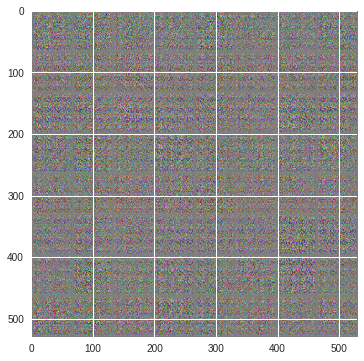

In [24]:
show(vutils.make_grid(fake))

Real images from dataset.

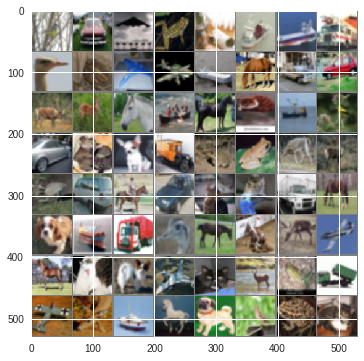

In [25]:
show(vutils.make_grid(iter(dataloader).next()[0]))